In [134]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import importlib
importlib.reload(load_data)
import load_data
from load_data import *

In [135]:
btc_forecast = pd.read_csv('btc_hourly_sim_45vol_20drift.csv')

In [136]:
df = load_data.btc_data()

In [137]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [143]:
df = pd.read_parquet('data/btc_data.parquet')
df['time'] = pd.to_datetime(df['time_close'])
df.set_index('time', inplace=True)
df = df[['price_close', 'volume_traded']].dropna()

# Create lagged features
for lag in range(1, 25):  # past 24 hours
    df[f'lag_{lag}'] = df['price_close'].shift(lag)


df['log_ret'] = np.log(df['price_close'] / df['price_close'].shift(1))
for lag in range(1, 25):
    df[f'ret_lag_{lag}'] = df['log_ret'].shift(lag)

df['rolling_mean_24'] = df['price_close'].rolling(24).mean()
df['rolling_std_24'] = df['price_close'].rolling(24).std()


df['volume_lag_1'] = df['volume_traded'].shift(1)
df['volume_change'] = df['volume_traded'].pct_change()


df.dropna(inplace=True)

In [144]:
df

,price_close,volume_traded,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,ret_lag_19,ret_lag_20,ret_lag_21,ret_lag_22,ret_lag_23,ret_lag_24,rolling_mean_24,rolling_std_24,volume_lag_1,volume_change
time,,,,,,,,,,,,,,,,,,,,,
2015-01-15 23:58:02+00:00,204.22,0.800000,224.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00,...,0.000000,0.000000,0.000000,0.000000,-0.438255,0.000484,152.592500,26.607046,0.165121,3.844940
2015-01-16 00:59:27+00:00,204.19,1.310000,204.22,224.00,150.00,150.00,150.00,150.00,150.00,150.00,...,0.470004,0.000000,0.000000,0.000000,0.000000,-0.438255,156.100417,27.652504,0.800000,0.637500
2015-01-16 01:49:45+00:00,203.00,0.810000,204.19,204.22,224.00,150.00,150.00,150.00,150.00,150.00,...,0.000000,0.470004,0.000000,0.000000,0.000000,0.000000,159.558750,28.127421,1.310000,-0.381679
2015-01-16 03:41:30+00:00,189.00,0.020000,203.00,204.19,204.22,224.00,150.00,150.00,150.00,150.00,...,-0.246860,0.000000,0.470004,0.000000,0.000000,0.000000,162.433750,27.425796,0.810000,-0.975309
2015-01-16 03:41:30+00:00,189.00,0.020000,189.00,203.00,204.19,204.22,224.00,150.00,150.00,150.00,...,0.000000,-0.246860,0.000000,0.470004,0.000000,0.000000,165.308750,26.380804,0.020000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-25 19:59:59.951345+00:00,87825.05,2246.495099,86956.07,87131.17,87351.80,87135.38,87083.80,88785.77,89374.50,89219.91,...,0.003711,-0.009974,-0.016406,-0.000098,0.001100,-0.003214,90059.180833,2306.985608,1665.925963,0.348496
2025-02-25 21:00:00.913653+00:00,88044.47,4465.769490,87825.05,86956.07,87131.17,87351.80,87135.38,87083.80,88785.77,89374.50,...,0.001880,0.003711,-0.009974,-0.016406,-0.000098,0.001100,89812.441667,2184.363974,2246.495099,0.987883
2025-02-25 21:59:59.963187+00:00,88706.81,738.370351,88044.47,87825.05,86956.07,87131.17,87351.80,87135.38,87083.80,88785.77,...,0.003685,0.001880,0.003711,-0.009974,-0.016406,-0.000098,89593.683750,2006.942237,4465.769490,-0.834660


In [167]:
X = df.drop('price_close', axis=1)
y = df['price_close'].shift(-1)  # target is next hour's price
df.dropna(inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


# Remove NaNs from X_train
X_train = X_train.dropna()

# Align y_train with cleaned X_train
y_train = y_train.loc[X_train.index]

# Drop any NaNs in y_train and re-align X_train
y_train = y_train.dropna()
X_train = X_train.loc[y_train.index]

In [155]:
# Step 1: Remove duplicates in index
X_train = X_train[~X_train.index.duplicated(keep='first')]
y_train = y_train[~y_train.index.duplicated(keep='first')]

In [156]:
X_test = X_test[~X_test.index.duplicated(keep='first')]
y_test = y_test[~y_test.index.duplicated(keep='first')]

In [157]:
# Train set
train_df = X_train.copy()
train_df['target'] = y_train
train_df.dropna(inplace=True)
X_train = train_df.drop('target', axis=1)
y_train = train_df['target']

# Test set
test_df = X_test.copy()
test_df['target'] = y_test
test_df.dropna(inplace=True)
X_test = test_df.drop('target', axis=1)
y_test = test_df['target']

In [158]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs = -1), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print(np.sqrt(-grid_search.best_score_))

11521.08994599457


In [159]:
rf_model = grid_search.best_estimator_
rf_preds = rf_model.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))

print(f"Random Forest RMSE: {rf_rmse:.2f}")

Random Forest RMSE: 12076.67


In [126]:
y_naive = y_test.shift(1)
valid_idx = y_naive.dropna().index  # keep only where lag exists
y_naive = y_naive.loc[valid_idx]
y_true_aligned = y_test.loc[valid_idx]

naive_rmse = np.sqrt(mean_squared_error(y_true_aligned, y_naive))
print(f"Naive RMSE: {naive_rmse:.2f}")

Naive RMSE: 247.96


In [127]:
X.index.equals(y.index)  # should return True

True

In [160]:
from sklearn.metrics import median_absolute_error
mae = median_absolute_error(y_test, rf_preds)
print(f"Random Forest MAE: {mae:.2f}")

Random Forest MAE: 282.87


In [161]:
# Construct row with same columns as X_train, in same order
latest_lags = latest['price_close'].values[::-1]
volume = latest['volume_traded'].iloc[-1]

# Build full feature row
data_dict = {f'lag_{i+1}': latest_lags[i] for i in range(24)}
data_dict['volume_traded'] = volume

# Create DataFrame in correct column order
features = pd.DataFrame([data_dict])[X_train.columns]

KeyError: "['log_ret', 'ret_lag_1', 'ret_lag_2', 'ret_lag_3', 'ret_lag_4', 'ret_lag_5', 'ret_lag_6', 'ret_lag_7', 'ret_lag_8', 'ret_lag_9', 'ret_lag_10', 'ret_lag_11', 'ret_lag_12', 'ret_lag_13', 'ret_lag_14', 'ret_lag_15', 'ret_lag_16', 'ret_lag_17', 'ret_lag_18', 'ret_lag_19', 'ret_lag_20', 'ret_lag_21', 'ret_lag_22', 'ret_lag_23', 'ret_lag_24', 'rolling_mean_24', 'rolling_std_24', 'volume_lag_1', 'volume_change'] not in index"

In [162]:
df['log_ret'] = np.log(df['price_close'] / df['price_close'].shift(1))
df.dropna(inplace=True)

In [163]:
import numpy as np
import pandas as pd

def classify_regime(ret):
    x = np.random.randint(0,3)
    if x == 0:
        return 'bull'
    elif x==  1:
        return 'bear'
    else:
        return 'base'

drift_params = {
    'bull': {'mu': 0.001822, 'sigma': 0.008948},
    'base': {'mu': 0.000055, 'sigma': 0.004940},
    'bear': {'mu': -0.002072, 'sigma': 0.011645}
}


def sample_drift(regime):
    p = drift_params[regime]
    return np.random.normal(loc=p['mu'], scale=p['sigma'])

In [164]:
def long_horizon_drift_forecast_rf(df, model, steps=8760):
    last_prices = df['price_close'].iloc[-24:].values[::-1]
    volume = df['volume_traded'].iloc[-1]
    feature_names = model.feature_names_in_

    forecast = []
    current_time = df.index[-1]

    for step in range(steps):
        features_dict = {f'lag_{i+1}': last_prices[i] for i in range(24)}
        features_dict['volume_traded'] = volume
        X_input = pd.DataFrame([features_dict])[feature_names]


                # Keep model as main signal, drift as noise
        pred_price = model.predict(X_input)[0]
        current_price = last_prices[0]
        predicted_return = (pred_price - current_price) / current_price
        regime = classify_regime(predicted_return)
        drift = sample_drift(regime)
        drift = np.clip(drift, -0.01, 0.01)
        next_price = pred_price * (1 + drift)  # Use model price as base
        current_time += pd.Timedelta(hours=1)

        forecast.append({
            'timestamp': current_time,
            'price': next_price,
            'regime': regime,
            'drift': drift
        })

        # Update lag memory
        last_prices = np.roll(last_prices, 1)
        last_prices[0] = next_price

    return pd.DataFrame(forecast).set_index('timestamp')

In [165]:
forecast_df = long_horizon_drift_forecast_rf(df, rf_model, steps=8760)
print(forecast_df.head(1)[['price', 'regime', 'drift']])

KeyError: "['log_ret', 'ret_lag_1', 'ret_lag_2', 'ret_lag_3', 'ret_lag_4', 'ret_lag_5', 'ret_lag_6', 'ret_lag_7', 'ret_lag_8', 'ret_lag_9', 'ret_lag_10', 'ret_lag_11', 'ret_lag_12', 'ret_lag_13', 'ret_lag_14', 'ret_lag_15', 'ret_lag_16', 'ret_lag_17', 'ret_lag_18', 'ret_lag_19', 'ret_lag_20', 'ret_lag_21', 'ret_lag_22', 'ret_lag_23', 'ret_lag_24', 'rolling_mean_24', 'rolling_std_24', 'volume_lag_1', 'volume_change'] not in index"

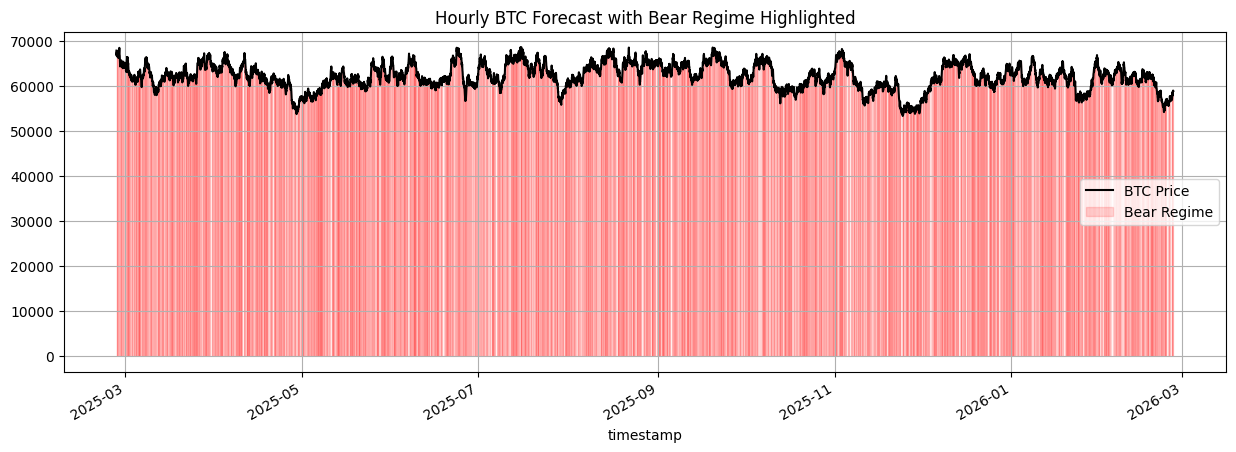

In [166]:
fig, ax = plt.subplots(figsize=(15, 5))
forecast_df['price'].plot(ax=ax, label='BTC Price', color='black')

# Plot only the 'bear' regime
mask = forecast_df['regime'] == 'base'
ax.fill_between(forecast_df.index,
                forecast_df['price'],
                where=mask,
                alpha=0.15,
                color='red',
                label='Bear Regime')

plt.legend()
plt.title("Hourly BTC Forecast with Bear Regime Highlighted")
plt.grid(True)